In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.lines import Line2D # Required for creating custom legend elements
# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Statistical libraries
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import os
import glob


class AdvancedEnergyAnalysis:
    """
    Advanced analysis class implementing multiple regression approach for energy cost analysis.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = {}
        self.models = {}
        self.data = None
        self.feature_names = None
        self.target_names = None
    
        # Set Nature journal plotting style
        plt.style.use('default')
        plt.rcParams.update({
            'font.family': 'Arial',
            'font.size': 32,  # 字体大小参数
            'axes.labelsize': 32,  # 轴标签字体大小
            'axes.titlesize': 32,  # 标题字体大小
            'xtick.labelsize': 32,  # X轴刻度标签字体大小
            'ytick.labelsize': 32,  # Y轴刻度标签字体大小
            'legend.fontsize': 32,  # 图例字体大小
            'figure.dpi': 300,  # 图形分辨率
            'savefig.dpi': 300,  # 保存图片分辨率
            'axes.linewidth': 1.5,  # 轴线宽度
            'grid.linewidth': 0.4,  # 网格线宽度
            'axes.spines.top': False,  # 顶部边框
            'axes.spines.right': False,  # 右侧边框
            'xtick.direction': 'out',  # X轴刻度方向
            'ytick.direction': 'out',  # Y轴刻度方向
            'axes.edgecolor': "#000000",  # 轴线颜色
            'text.color': '#000000',  # 文字颜色
            'axes.labelcolor': '#000000',  # 轴标签颜色
            'xtick.color': '#000000',  # X轴刻度颜色
            'ytick.color': '#000000'  # Y轴刻度颜色
        })
    
    def calculate_real_data(self):
        """
        Calculate comprehensive island energy system data for both 2020 and 2050 scenarios.
        """
        print("Loading and preparing island energy system data for 2020 and 2050 scenarios...")
        
        islands_df = pd.read_csv('../result/island_data_origin.csv')
        results_data = []
        
        scenarios = {
            2020: {'output_dir': '../result/output_2020', 'cost_summary_file': '../result/island_cost_summary_2020.csv'},
            2050: {'output_dir': '../result/output_2050', 'cost_summary_file': '../result/island_cost_summary_2050.csv'}
        }
        
        windspeed_dir = '../result/island_windspeed_data'
        demand_dir = '../demand_get/data/get1'
        
        for year, config in scenarios.items():
            print(f"Processing {year} scenario...")
            cost_summary_df = pd.read_csv(config['cost_summary_file'])
            
            for _, island in islands_df.iterrows():
                lat, lon = island['Lat'], island['Long']
                
                windspeed_file = os.path.join(windspeed_dir, f"{lat}_{lon}_{year}_windspeed.csv")
                output_file = os.path.join(config['output_dir'], f"{lat}_{lon}_results.csv")
                demand_file = os.path.join(demand_dir, f"demand_{lat}_{lon}.csv")
                
                cost_data = cost_summary_df[(cost_summary_df['lat'] == lat) & (cost_summary_df['lon'] == lon)]

                if os.path.exists(windspeed_file) and os.path.exists(output_file) and os.path.exists(demand_file) and not cost_data.empty:
                    try:
                        wind_df = pd.read_csv(windspeed_file)
                        wind_col = f'Wind_Speed_{year}' if f'Wind_Speed_{year}' in wind_df.columns else wind_df.columns[0]
                        wind_speeds = wind_df[wind_col]
                        # pdi = (wind_speeds ** 3).sum()
                        pdi = (wind_speeds[wind_speeds > 20] ** 3).sum()

                        # 加载供暖需求数据
                        demand_df = pd.read_csv(demand_file)
                        heating_demand = demand_df.get('heating_demand', pd.Series(0)).sum()

                        output_df = pd.read_csv(output_file)
                        e_wt = output_df.get('WT', pd.Series(0)).sum()
                        e_pv = output_df.get('PV', pd.Series(0)).sum()
                        e_wec = output_df.get('WEC', pd.Series(0)).sum()
                        e_chp = output_df.get('CHP_electric_output', pd.Series(0)).sum()

                        renewable_energy = e_wt + e_pv + e_wec
                        total_energy = renewable_energy + e_chp
                        renewable_penetration = renewable_energy / total_energy if total_energy > 0 else 0

                        cost_data_row = cost_data.iloc[0]

                        results_data.append({
                            'ID': island['ID'], 'Long': lon, 'Lat': lat, 'Country': island['Country'],
                            'Island': island['Island'], 'Population': island['pop'], 'Year': year,
                            'PDI': pdi,
                            'Heating_Demand': heating_demand,
                            'Renewable_Penetration': renewable_penetration,
                            'Renewable_Cost': cost_data_row.get('renewable_cost_per_capita', 0),
                            'Total_Storage_Investment': cost_data_row.get('storage_cost_per_capita', 0),
                            'LNG_Cost': cost_data_row.get('lng_cost_per_capita', 0)
                        })
                    except Exception as e:
                        # print(f"Skipping island {lat},{lon} for {year} due to error: {e}")
                        continue
        
        analysis_df = pd.DataFrame(results_data)
        if analysis_df.empty:
            print("❌ Error: No data available for analysis")
            return None
        
        self.data = analysis_df.dropna()
        print(f"Data loaded successfully: {len(self.data)} records")
        
        # 设置自变量和因变量
        self.feature_names = ['PDI', 'Heating_Demand', 'Renewable_Penetration']
        self.target_names = ['Renewable_Cost', 'Total_Storage_Investment', 'LNG_Cost']
        
        return self.data

    def apply_data_cleaning(self, strategy='moderate'):
        """
        Apply data cleaning strategy.
        """
        if self.data is None:
            print("❌ Error: No data loaded")
            return None
        
        print(f"\n🔧 Applying {strategy.upper()} data cleaning strategy...")
        df_cleaned = self.data.copy()
        original_count = len(df_cleaned)
        
        # Remove cases where all investment costs are zero, as they represent unoptimized scenarios
        mask_all_zero = (
            (df_cleaned['Renewable_Cost'] == 0) & 
            (df_cleaned['Total_Storage_Investment'] == 0) & 
            (df_cleaned['LNG_Cost'] == 0)
        )
        df_cleaned = df_cleaned[~mask_all_zero]
        
        final_count = len(df_cleaned)
        removed_count = original_count - final_count
        print(f"  • Original records: {original_count}")
        print(f"  • Final records: {final_count} (Removed: {removed_count}, {removed_count/original_count:.1%})")
        
        self.data = df_cleaned
        return df_cleaned

    def get_significance_stars(self, p_value):
        """
        返回显著性星号标记
        """
        if p_value < 0.001:
            return "***"
        elif p_value < 0.01:
            return "**"
        elif p_value < 0.05:
            return "*"
        else:
            return ""

    def perform_multiple_regression_analysis(self):
        """
        Perform three separate multiple regression analyses with significance testing:
        Independent variables: PDI, Heating_Demand, Renewable_Penetration
        Dependent variables: Renewable_Cost, Total_Storage_Investment, LNG_Cost
        """
        print("\n" + "="*80)
        print("📊 MULTIPLE REGRESSION ANALYSIS WITH SIGNIFICANCE TESTING")
        print("="*80)
        
        # 检查数据是否包含所需变量
        missing_vars = [var for var in self.feature_names + self.target_names if var not in self.data.columns]
        if missing_vars:
            print(f"❌ Missing variables: {missing_vars}")
            return None
        
        regression_results = {}
        X = self.data[self.feature_names]
        
        print(f"\n📋 Independent Variables: {', '.join(self.feature_names)}")
        print(f"📋 Sample Size: {len(self.data)}")
        
        # 检查多重共线性
        print("\n🔍 Multicollinearity Check (VIF):")
        X_scaled = StandardScaler().fit_transform(X)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = self.feature_names
        vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(len(self.feature_names))]
        
        for _, row in vif_data.iterrows():
            status = "⚠️ High" if row["VIF"] > 5 else "✅ OK"
            print(f"  {row['Variable']}: {row['VIF']:.2f} ({status})")
        
        # 对每个因变量进行多元回归分析
        for target in self.target_names:
            print(f"\n" + "-"*60)
            print(f"🎯 Multiple Regression for {target.replace('_', ' ')}")
            print("-"*60)
            
            y = self.data[target]
            
            # 数据分割
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.random_state)
            
            # 标准化特征
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # sklearn模型训练
            model = LinearRegression()
            model.fit(X_train_scaled, y_train)
            
            # 预测和评估
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
            
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # 交叉验证
            X_scaled_full = scaler.fit_transform(X)
            cv_scores = cross_val_score(model, X_scaled_full, y, cv=5, scoring='r2')
            
            # 使用statsmodels进行显著性检验
            X_train_with_const = sm.add_constant(X_train_scaled)  # 添加常数项用于截距
            model_sm = sm.OLS(y_train, X_train_with_const).fit()
            
            # 输出基本结果
            print(f"  📈 Training R²: {train_r2:.4f}")
            print(f"  📈 Test R²: {test_r2:.4f}")
            print(f"  📈 Cross-validation R² (mean±std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            print(f"  📏 Test RMSE: {test_rmse:.2f}")
            print(f"  📏 Test MAE: {test_mae:.2f}")
            
            # 模型整体显著性检验
            print(f"\n  📊 Model Significance:")
            print(f"    F-statistic: {model_sm.fvalue:.4f}")
            f_p_value = model_sm.f_pvalue
            f_stars = self.get_significance_stars(f_p_value)
            print(f"    F-test p-value: {f_p_value:.4f} {f_stars}")
            
            if f_p_value < 0.05:
                print(f"    ✅ Model is statistically significant (p < 0.05)")
            else:
                print(f"    ❌ Model is NOT statistically significant (p ≥ 0.05)")
            
            # 回归系数分析和显著性检验
            print(f"\n  🔍 Regression Coefficients with Significance Testing:")
            print(f"    {'Variable':<25} {'Coefficient':<12} {'p-value':<10} {'Significance':<12}")
            print(f"    {'-'*25} {'-'*12} {'-'*10} {'-'*12}")
            
            coef_df = pd.DataFrame({
                'Variable': self.feature_names,
                'Coefficient': model.coef_,
                'p_value': model_sm.pvalues[1:],  # 跳过截距的p值
                'Abs_Coefficient': np.abs(model.coef_)
            }).sort_values('Abs_Coefficient', ascending=False)
            
            for _, row in coef_df.iterrows():
                direction = "+" if row['Coefficient'] > 0 else "-"
                stars = self.get_significance_stars(row['p_value'])
                significance_text = "Significant" if row['p_value'] < 0.05 else "Not Sig."
                print(f"    {row['Variable']:<25} {row['Coefficient']:>8.4f} ({direction}) {row['p_value']:>8.4f} {stars:<3} {significance_text}")
            
            # 显著性说明
            print(f"\n  📝 Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
            
            # 保存结果
            regression_results[target] = {
                'model': model,
                'model_sm': model_sm,  # 添加statsmodels结果
                'scaler': scaler,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'cv_scores': cv_scores,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'coefficients': model.coef_,
                'intercept': model.intercept_,
                'feature_names': self.feature_names,
                'y_test': y_test,
                'y_pred_test': y_pred_test,
                'coef_df': coef_df,
                'f_statistic': model_sm.fvalue,
                'f_pvalue': model_sm.f_pvalue,
                'coef_pvalues': model_sm.pvalues[1:]  # 系数的p值（不包括截距）
            }
        
        self.models['multiple_regression'] = regression_results
        self.results['multiple_regression'] = regression_results
        
        # 生成可视化
        self.visualize_multiple_regression_results()
        
        return regression_results

    def visualize_multiple_regression_results(self):
        """
        Visualize multiple regression results with significance indicators.
        """
        # 主图：回归系数对比（包含显著性标记）
        # 使用2行2列布局，第一行两个图，第二行左边一个图
        fig = plt.figure(figsize=(22, 12), dpi=300)  # 图形尺寸参数：宽度16，高度12

        # 创建子图：第一行两个图，第二行左边一个图
        ax1 = plt.subplot(2, 2, 1)  # 第一行第一列
        ax2 = plt.subplot(2, 2, 2)  # 第一行第二列
        ax3 = plt.subplot(2, 2, 3)  # 第二行第一列，与第一个图同样大小

        axes = [ax1, ax2, ax3]
        
        colors = ['#4C72B0', '#55A868', '#808080']  # 三种成本类型的指定颜色
        
        # 成本类型标签映射
        cost_labels = {
            'Renewable_Cost': 'Renewable Generation Cost',
            'Total_Storage_Investment': 'Energy Storage System Cost', 
            'LNG_Cost': 'LNG Cost'
        }
        
        # 自变量标签映射
        feature_labels = {
            'PDI': 'Hazard Intensity',
            'Heating_Demand': 'Heating Demand',
            'Renewable_Penetration': 'Renewable Penetration'
        }
        
        for i, target in enumerate(self.target_names):
            ax = axes[i]
            results = self.results['multiple_regression'][target]
            coef_df = results['coef_df']
            
            # 绘制系数条形图
            y_positions = np.arange(len(coef_df))  # Y轴位置
            
            # 根据显著性设置颜色透明度
            alphas = [0.9 if p < 0.05 else 0.4 for p in coef_df['p_value']]  # 显著性透明度设置
            
            for j, (_, row) in enumerate(coef_df.iterrows()):
                alpha = alphas[j]
                bars = ax.barh(y_positions[j], row['Coefficient'], 
                              color=colors[i], alpha=alpha,  # 颜色和透明度参数
                              edgecolor='white', linewidth=1)  # 边框设置参数
            
            # 设置Y轴标签
            feature_labels_list = [feature_labels[var] for var in coef_df['Variable']]
            ax.set_yticks(y_positions)  # Y轴刻度位置
            ax.set_yticklabels(feature_labels_list)  # Y轴刻度标签
            
            # 添加显著性星号
            for j, (_, row) in enumerate(coef_df.iterrows()):
                stars = self.get_significance_stars(row['p_value'])
                if stars:
                    # 在条形图右侧添加星号
                    x_pos = row['Coefficient'] + (0.1 * max(abs(coef_df['Coefficient'])))
                    if row['Coefficient'] < 0:
                        # x_pos = row['Coefficient'] - (0.1 * max(abs(coef_df['Coefficient'])))
                        x_pos = 10
                    ax.text(x_pos, y_positions[j], stars, 
                           verticalalignment='center', fontsize=16, fontweight='bold')  # 星号显示参数
            
            # 添加零参考线
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)  # 零线参数
            
            # 设置标签
            ax.set_xlabel('Standardized Coefficient')  # X轴标签
            
            # 移除网格和顶部/右侧边框
            ax.grid(False)  # 网格参数
            ax.spines['top'].set_visible(False)  # 顶部边框
            ax.spines['right'].set_visible(False)  # 右侧边框
        
        # 添加显著性说明
        # legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='gray', alpha=0.9, 
        #                                    edgecolor='white', linewidth=1, label='Significant (p < 0.05)')
        # legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='gray', alpha=0.4, 
        #                                    edgecolor='white', linewidth=1, label='Not significant (p ≥ 0.05)'))

        # 添加R²和F检验信息
        # r2_text = f"R² = {results['test_r2']:.3f}"  # R²文本格式
        # f_stars = self.get_significance_stars(results['f_pvalue'])
        # f_text = f"F-test: {f_stars}" if f_stars else "F-test: n.s."  # F检验显著性标记
        # info_text = f"{r2_text}\n{f_text}"
        # ax.text(0.95, 0.95, info_text, transform=ax.transAxes,  # 文本位置参数
        #        verticalalignment='top', horizontalalignment='right',
        #        fontsize=18, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))  # 文本框样式参数

        plt.tight_layout(pad=2.0)  # 自动调整布局，增加子图间距参数
        plt.show()
        
        # 单独的图例（包含显著性说明）
        fig_legend = plt.figure(figsize=(8, 3))  # 图例图形尺寸
        ax_legend = fig_legend.add_subplot(111)
        ax_legend.axis('off')  # 关闭坐标轴显示
        
        # 创建图例元素
        legend_elements = []
        for i, target in enumerate(self.target_names):
            cost_label = cost_labels[target]
            color = colors[i]
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.9, 
                                               edgecolor='white', linewidth=1, label=cost_label))
        
        # 创建图例
        legend = ax_legend.legend(handles=legend_elements,
                                loc='center',  # 图例位置
                                frameon=False,  # 图例边框
                                fontsize=20,  # 图例字体大小
                                ncol=1,  # 图例列数
                                columnspacing=2)  # 列间距参数
        
        # 添加显著性符号说明
        ax_legend.text(0.5, -0.1, '*** p<0.001, ** p<0.01, \n* p<0.05', 
                      transform=ax_legend.transAxes, ha='center', fontsize=20)  # 显著性说明文本
        
        plt.tight_layout()
        plt.show()

    def generate_regression_summary(self):
        """
        Generate a comprehensive summary of multiple regression results with significance testing.
        """
        print("\n" + "="*80)
        print("📋 MULTIPLE REGRESSION ANALYSIS SUMMARY WITH SIGNIFICANCE")
        print("="*80)
        
        print(f"\n🎯 Analysis Overview:")
        print(f"  • Sample Size: {len(self.data)}")
        print(f"  • Independent Variables: {', '.join(self.feature_names)}")
        print(f"  • Dependent Variables: {', '.join([name.replace('_', ' ') for name in self.target_names])}")
        
        print(f"\n📊 Model Performance and Significance:")
        for target in self.target_names:
            results = self.results['multiple_regression'][target]
            r2 = results['test_r2']
            cv_mean = results['cv_scores'].mean()
            cv_std = results['cv_scores'].std()
            f_pvalue = results['f_pvalue']
            f_stars = self.get_significance_stars(f_pvalue)
            
            significance_status = "✅ Significant" if f_pvalue < 0.05 else "❌ Not Significant"
            print(f"  • {target.replace('_', ' '):<30}: R² = {r2:.4f} (CV: {cv_mean:.4f}±{cv_std:.4f})")
            print(f"    {'':32} F-test: p = {f_pvalue:.4f} {f_stars} ({significance_status})")
        
        print(f"\n🔍 Significant Predictors by Model:")
        for target in self.target_names:
            results = self.results['multiple_regression'][target]
            coef_df = results['coef_df']
            significant_vars = coef_df[coef_df['p_value'] < 0.05].sort_values('Abs_Coefficient', ascending=False)
            
            print(f"  • {target.replace('_', ' '):<30}:")
            if len(significant_vars) > 0:
                for _, row in significant_vars.iterrows():
                    direction = "+" if row['Coefficient'] > 0 else "-"
                    stars = self.get_significance_stars(row['p_value'])
                    print(f"    - {row['Variable']:<25}: {row['Coefficient']:>8.4f} ({direction}) {stars}")
            else:
                print(f"    - No significant predictors found")
        
        print("\n" + "="*80)
        print("✅ MULTIPLE REGRESSION ANALYSIS WITH SIGNIFICANCE TESTING COMPLETED!")
        print("="*80)

Multiple Regression Analysis for Energy System Investment
Independent Variables: PDI, Heating Demand, Renewable Penetration
Dependent Variables: Renewable Cost, Storage Cost, LNG Cost

Loading and preparing island energy system data for 2020 and 2050 scenarios...
Processing 2020 scenario...
Processing 2050 scenario...
Data loaded successfully: 3450 records

🔧 Applying MODERATE data cleaning strategy...
  • Original records: 3450
  • Final records: 3450 (Removed: 0, 0.0%)

📊 MULTIPLE REGRESSION ANALYSIS WITH SIGNIFICANCE TESTING

📋 Independent Variables: PDI, Heating_Demand, Renewable_Penetration
📋 Sample Size: 3450

🔍 Multicollinearity Check (VIF):
  PDI: 1.02 (✅ OK)
  Heating_Demand: 1.22 (✅ OK)
  Renewable_Penetration: 1.21 (✅ OK)

------------------------------------------------------------
🎯 Multiple Regression for Renewable Cost
------------------------------------------------------------
  📈 Training R²: 0.2645
  📈 Test R²: 0.2678
  📈 Cross-validation R² (mean±std): 0.2838 ± 0.31

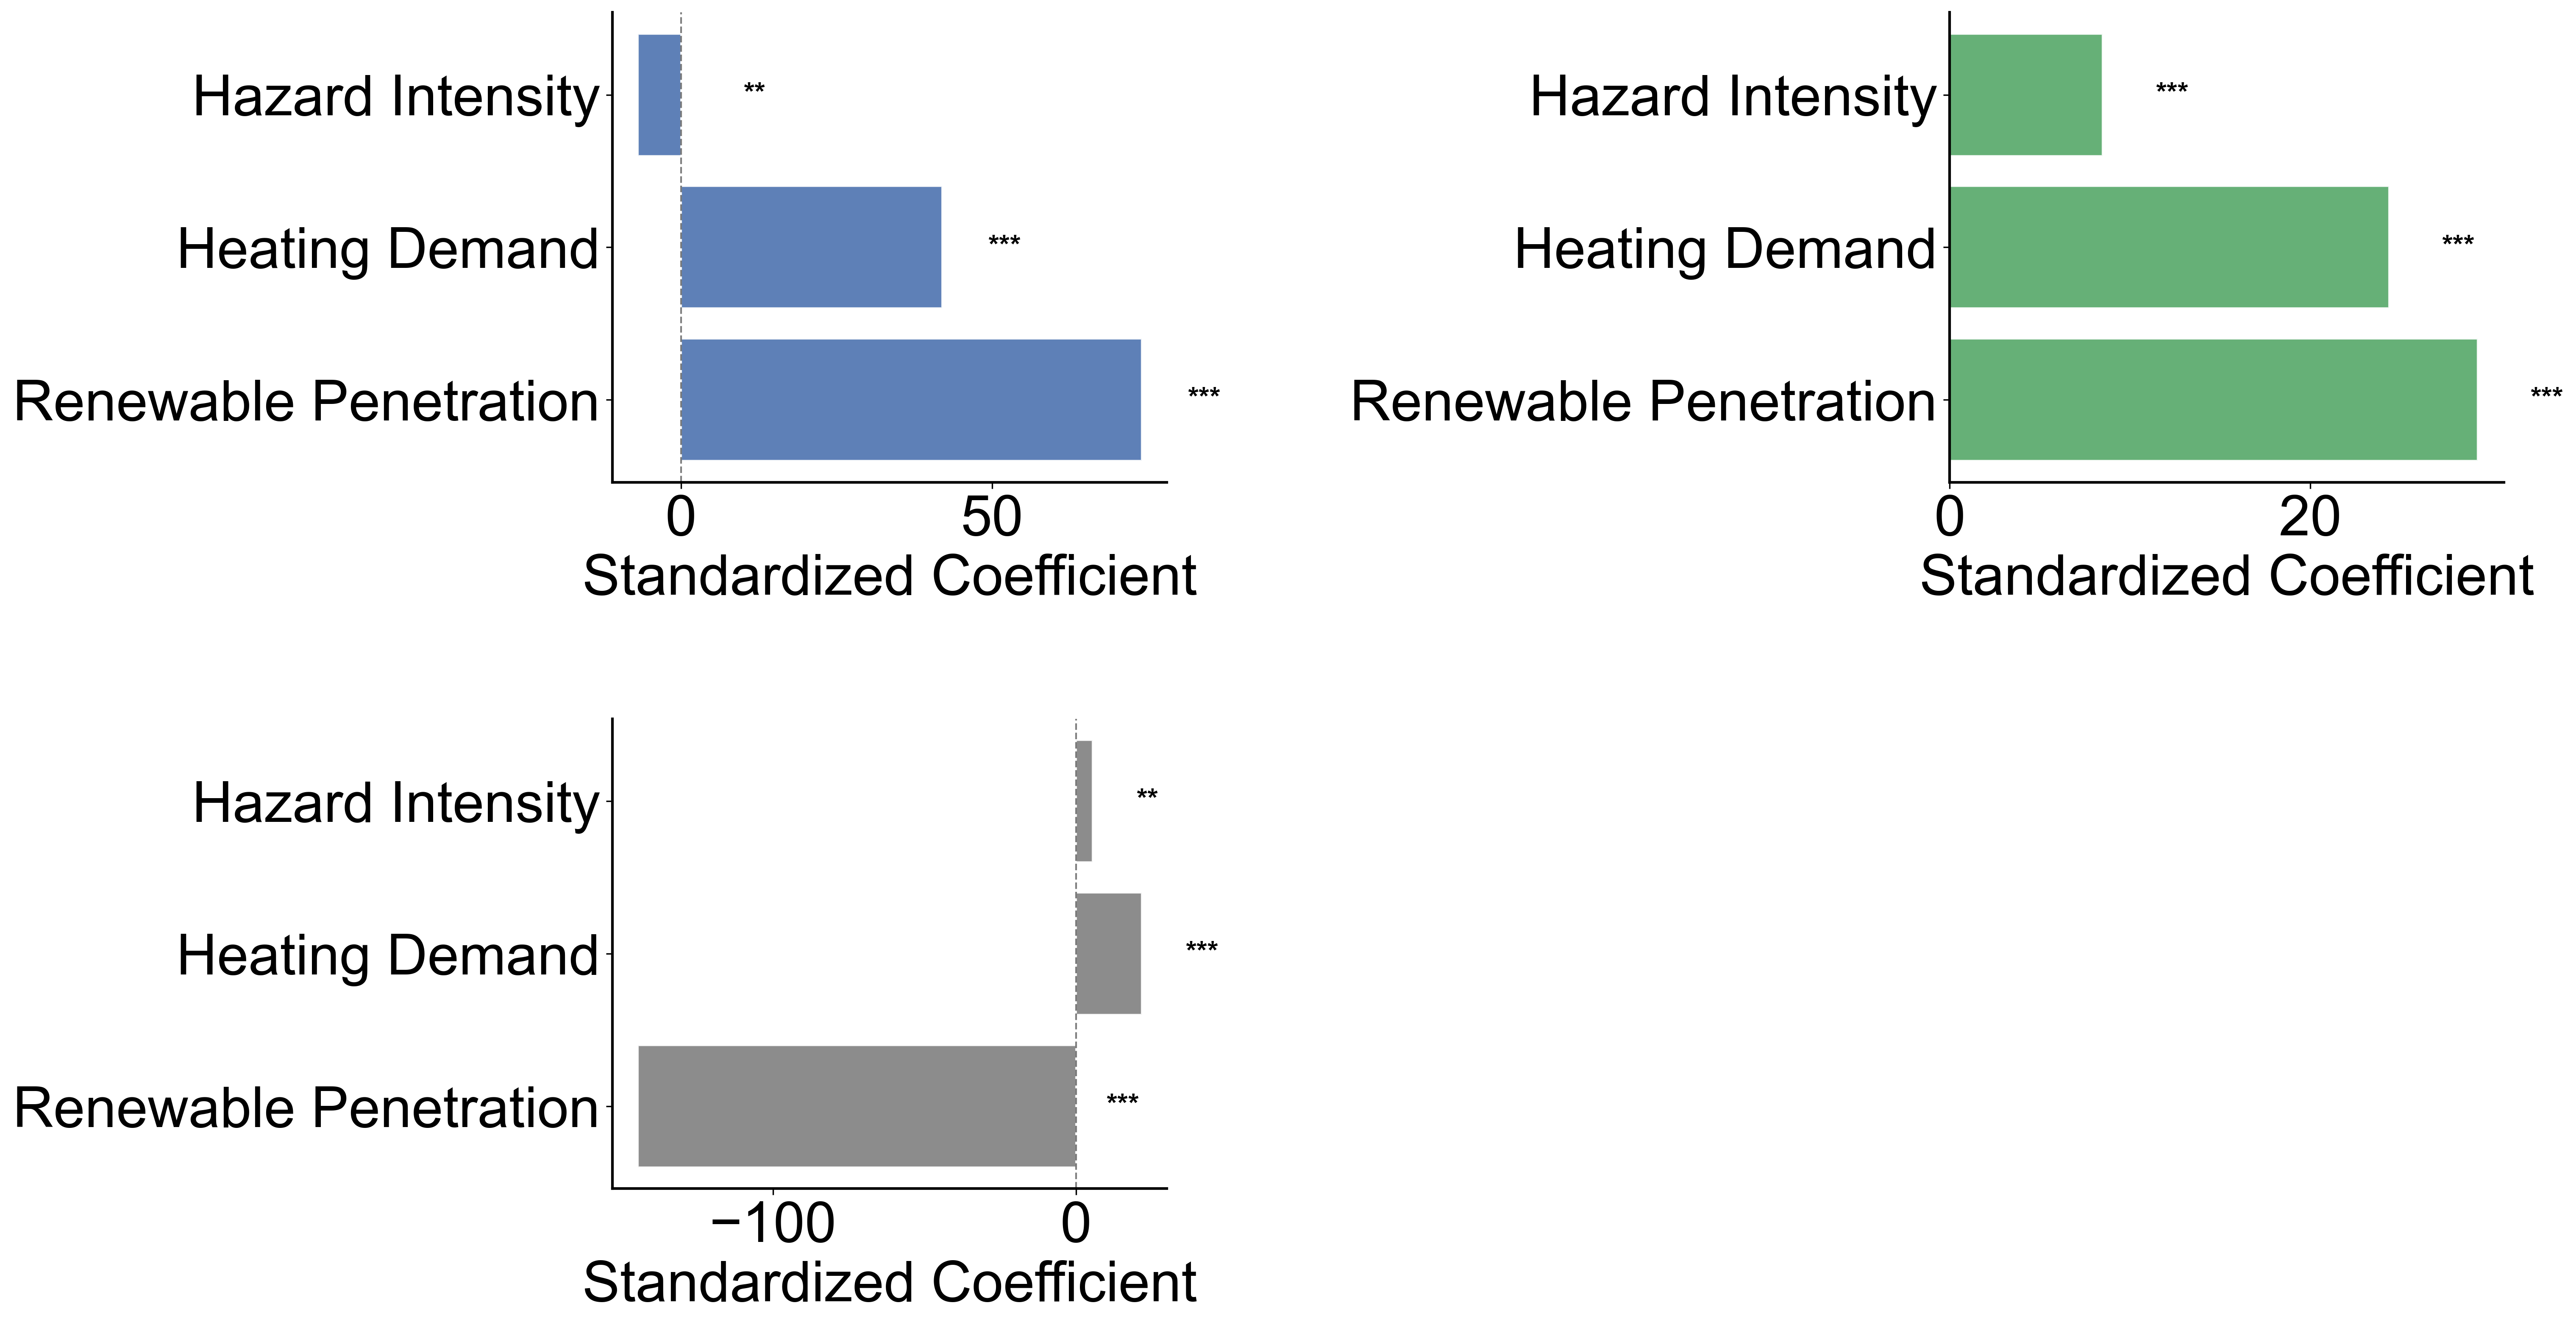

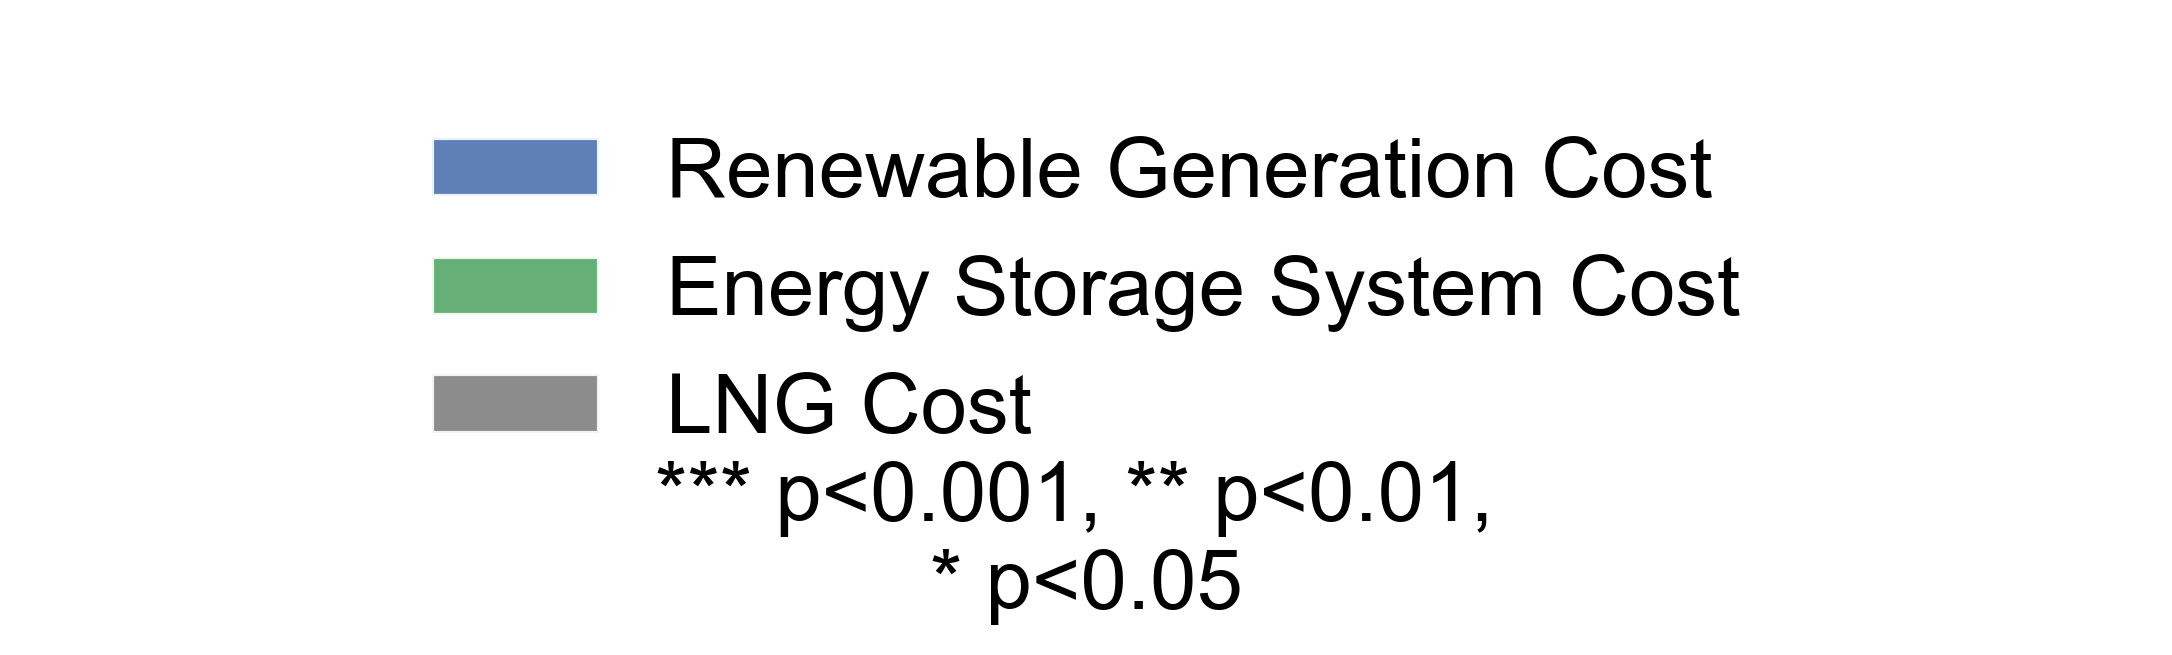


📋 MULTIPLE REGRESSION ANALYSIS SUMMARY WITH SIGNIFICANCE

🎯 Analysis Overview:
  • Sample Size: 3450
  • Independent Variables: PDI, Heating_Demand, Renewable_Penetration
  • Dependent Variables: Renewable Cost, Total Storage Investment, LNG Cost

📊 Model Performance and Significance:
  • Renewable Cost                : R² = 0.2678 (CV: 0.2838±0.3102)
                                     F-test: p = 0.0000 *** (✅ Significant)
  • Total Storage Investment      : R² = 0.0364 (CV: -0.1924±0.2092)
                                     F-test: p = 0.0000 *** (✅ Significant)
  • LNG Cost                      : R² = 0.6878 (CV: 0.7071±0.0623)
                                     F-test: p = 0.0000 *** (✅ Significant)

🔍 Significant Predictors by Model:
  • Renewable Cost                :
    - Renewable_Penetration    :  74.0800 (+) ***
    - Heating_Demand           :  41.9720 (+) ***
    - PDI                      :  -6.9854 (-) **
  • Total Storage Investment      :
    - Renewable_Penetra

In [26]:
if __name__ == "__main__":
    import pickle
    
    analyzer = AdvancedEnergyAnalysis(random_state=42)
    
    print("Multiple Regression Analysis for Energy System Investment")
    print("Independent Variables: PDI, Heating Demand, Renewable Penetration")
    print("Dependent Variables: Renewable Cost, Storage Cost, LNG Cost\n")
    
    # 数据加载和清理
    df = analyzer.calculate_real_data()
    if df is None:
        exit(1)
    
    df_cleaned = analyzer.apply_data_cleaning(strategy='moderate')
    if len(df_cleaned) < 30:
        print("❌ Insufficient data after cleaning. Halting analysis.")
        exit(1)
    
    try:
        # 执行多元回归分析
        regression_results = analyzer.perform_multiple_regression_analysis()
        
        if regression_results:
            # 生成综合报告
            analyzer.generate_regression_summary()
            
            # 保存结果
            with open('multiple_regression_results.pkl', 'wb') as f:
                pickle.dump(regression_results, f)
            print("\n💾 Results saved to 'multiple_regression_results.pkl'")
        else:
            print("❌ Multiple regression analysis failed.")
          
    except Exception as e:
        print(f"\n❌ Analysis failed with error: {str(e)}")
        import traceback
        traceback.print_exc()